# Guitar tuner experiment 3

This experiment only use fixed time divisions to do the guessing. It will help for the real case

In [5]:
import warnings

import numpy as np
from scipy.fftpack import rfft
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.cluster.vq import whiten, kmeans2, vq
from sklearn.cluster import KMeans

import fftlib

In [18]:
SOUNDS = [
    ("mi82.4", 82.41, "sounds/guitar/082.4_mi_1.wav"),
    ("la110", 110, "sounds/guitar/110_la_1.wav"),
    ("re146.8", 146.8, "sounds/guitar/146.8_re_1.wav"),
    ("sol196", 196, "sounds/guitar/196_sol_1.wav"),
    ("si246.9", 246.9, "sounds/guitar/246.9_si_1.wav"),
    ("mi329.6", 329.6, "sounds/guitar/329.6_mi_1.wav"),
]
_ = [
    ("mi82.4", 82.41, "sounds/guitar/082.4_mi_2.wav"),
    ("la110", 110, "sounds/guitar/110_la_2.wav"),
    ("re146.8", 146.8, "sounds/guitar/146.8_re_2.wav"),
    ("sol196", 196, "sounds/guitar/196_sol_2.wav"),
    ("si246.9", 246.9, "sounds/guitar/246.9_si_2.wav"),
    ("mi329.6", 329.6, "sounds/guitar/329.6_mi_2.wav"),
]

SAMPLE_DUR = 200. / 1000.


# Creates [(rate, data), ...]:
WAVES = [wavfile.read(filename) for _, _, filename in SOUNDS]
DURATIONS = [len(data)/rate for rate, data in WAVES]

# SAMPLES: [ [sample1_note1, sample2_note2, ...], [...], ...]
SAMPLES = [
    fftlib.sampling(rate, data.T, SAMPLE_DUR)
    for (rate, data) in WAVES
]

FOURIER_SAMPLES = [[] for _ in SOUNDS]
FREQUENCIES = [None for _ in SOUNDS]

for i, sound in enumerate(SAMPLES):
    for j, sample in enumerate(sound):
        FREQUENCIES[i], amp = fftlib.analysis(WAVES[i][0], sample)
        FOURIER_SAMPLES[i].append(amp)

/usr/local/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


## First test: Use a fixed window length and assume there is a note in every window

/usr/local/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:968: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)


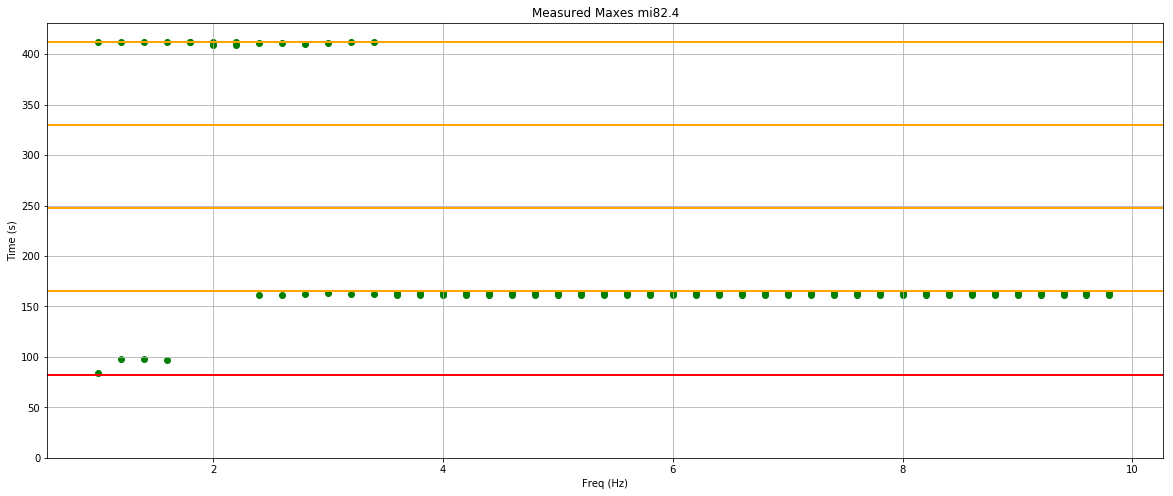

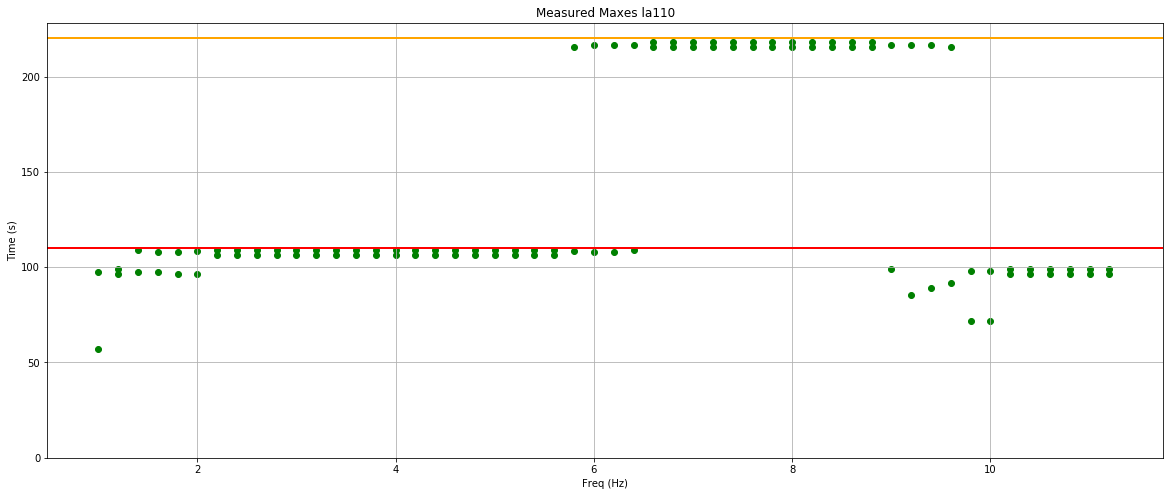

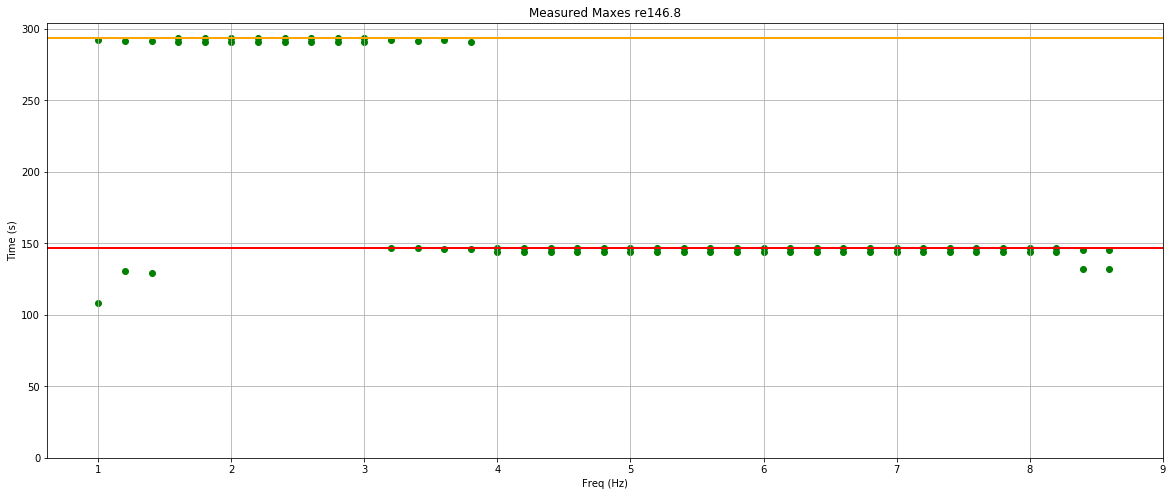

/usr/local/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:968: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
/usr/local/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:968: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
/usr/local/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:968: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)


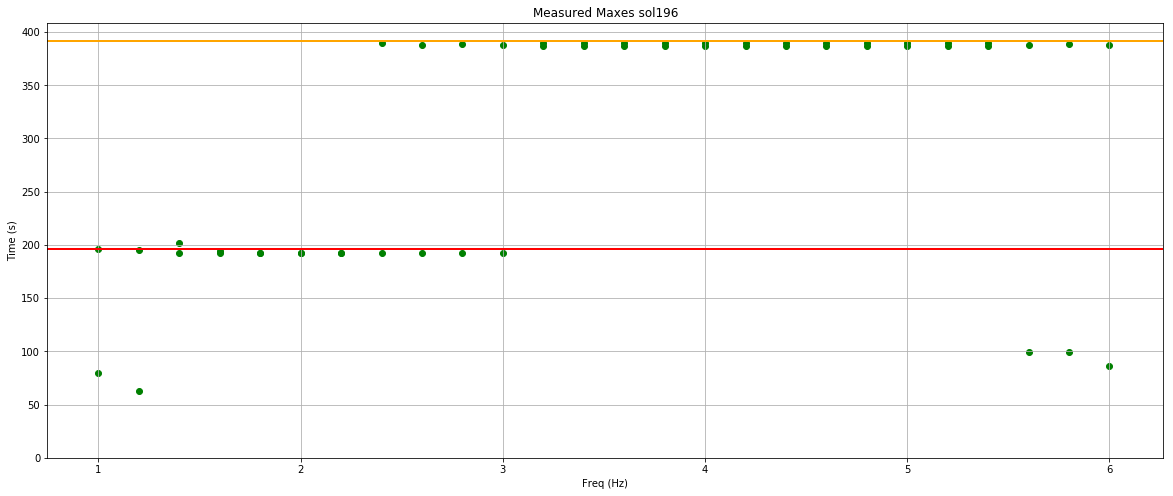

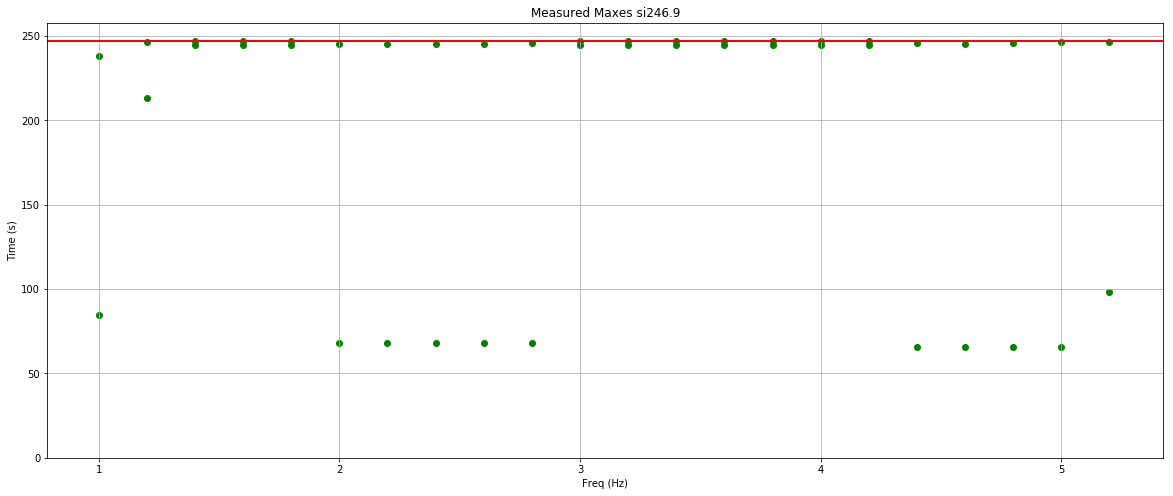

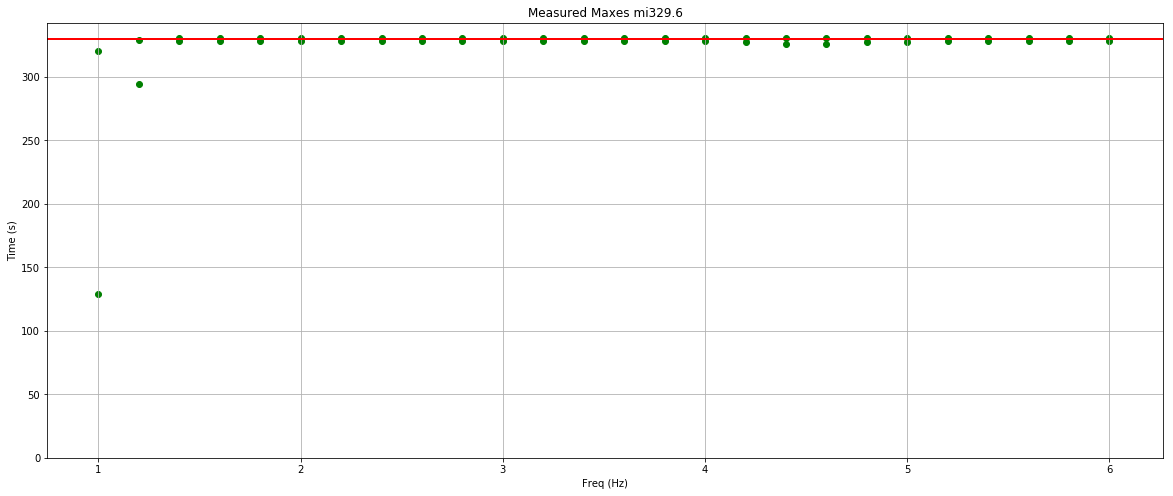

In [19]:
matplotlib.rcParams['figure.figsize'] = (20.0, 8.0)


WINDOW_LEN = 5
N_CLUSTERS = 2
AMP = 10000

for i, fourier, freq, sound in zip(range(len(SOUNDS)), FOURIER_SAMPLES, FREQUENCIES, SOUNDS):
    for w in range(WINDOW_LEN, len(fourier)):
        window = fourier[w-WINDOW_LEN:w]
        # print(len(window))
        # Here filter the smallest values
        # for some reason kmeans does not work with np.masks
        loudest = np.max(window)
        maxes = np.array([(freq[np.argmax(amp)], np.max(amp)) for amp in window if np.max(amp) > loudest / AMP])

        shaped_maxes = maxes.T[0].reshape(-1, 1)

        kmeans = KMeans(
                n_clusters=N_CLUSTERS,
                random_state=0
            ).fit(shaped_maxes)
        centers = kmeans.cluster_centers_

        # plt.scatter(
        #     y=maxes.T[0],
        #     x=[w*SAMPLE_DUR for _ in range(len(maxes.T[0]))],
        #     s=maxes.T[1],
        # )
        plt.axhline(y=sound[1], color="red")
        M = 2
        while max(maxes.T[0])*1.1 > sound[1]*M:
            plt.axhline(y=sound[1]*M, color="orange")
            M += 1
        for center in centers:
            plt.scatter(
                y=center,
                x=w*SAMPLE_DUR,
                c="green",
            )
    plt.xlabel("Freq (Hz)")
    plt.ylabel("Time (s)")
    plt.title(f"Measured Maxes {sound[0]}")
    plt.ylim(bottom=0)
    plt.grid()
    plt.show()

        # arg_center_with_max_points = 0
        # max_points = 0
        # for j in range(len(centers)):
        #     mask = np.ma.masked_where(kmeans.labels_ != i, maxes.T[0])
        #     print(centers)
        #     if mask.count() > max_points:
        #         arg_center_with_max_points = j
        #         max_points = mask.count()
        # print(center[arg_center_with_max_points], max_points)
        # MEASURED_NOTES[i] = centers[arg_center_with_max_points]

## Second test: use the estimator created in Experiment3

The only difference with experiment 3 is that we do not have enought points to filter too much the data from the max cluster, we would endup with only one point in each cluster

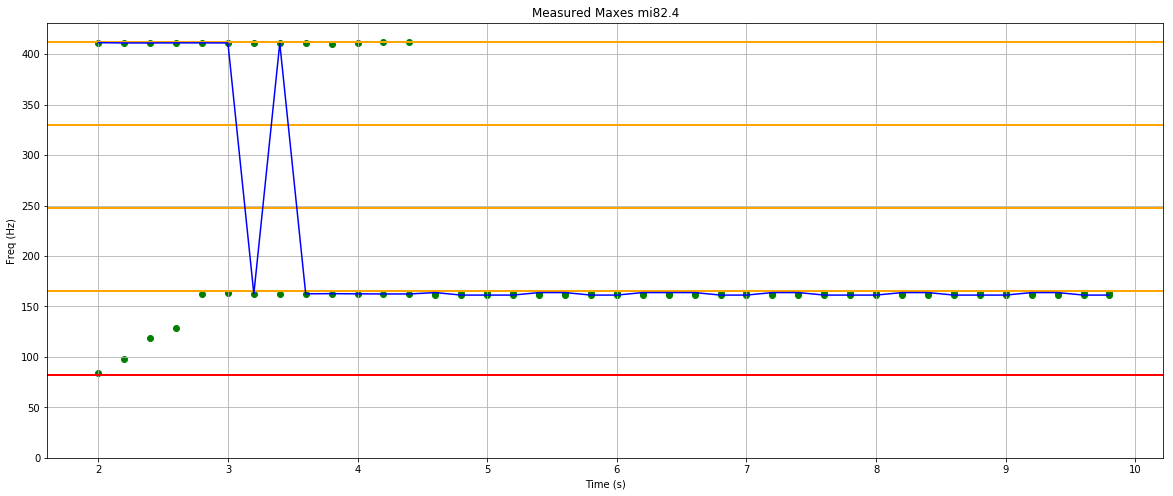

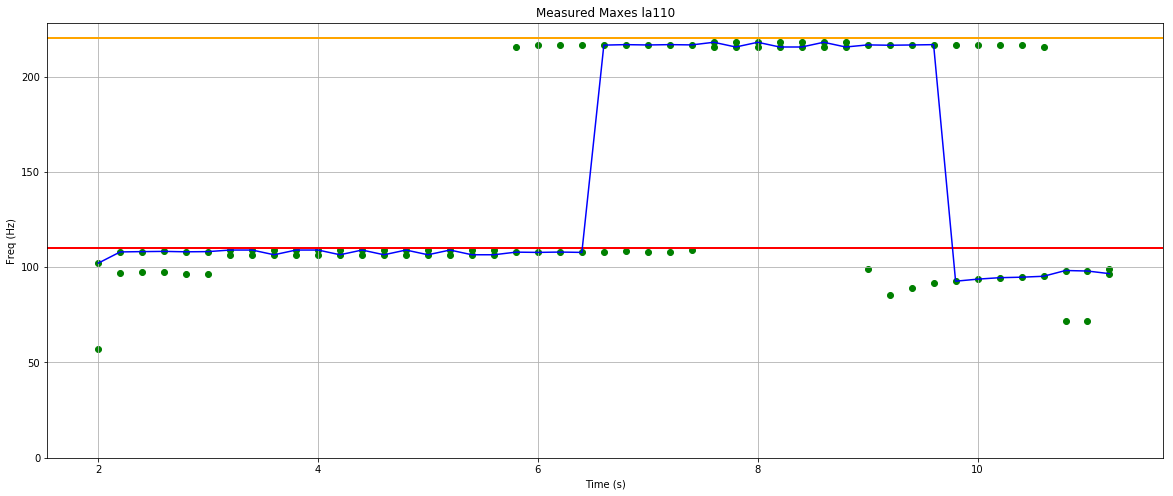

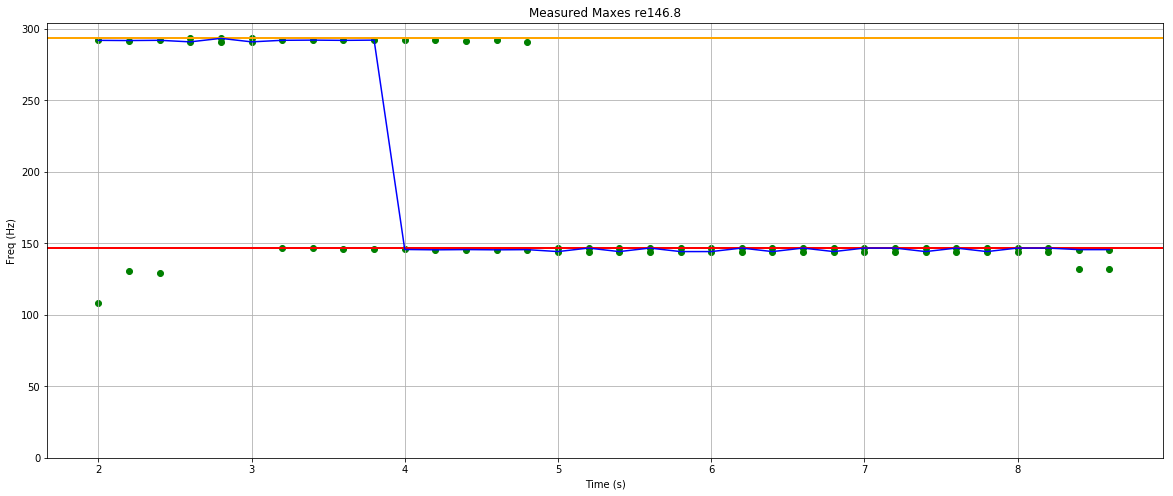

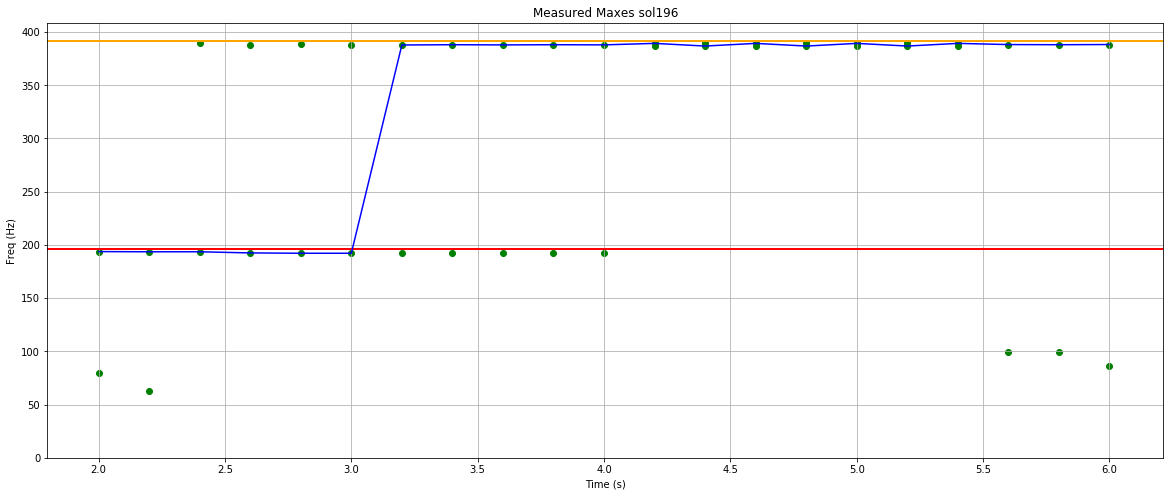

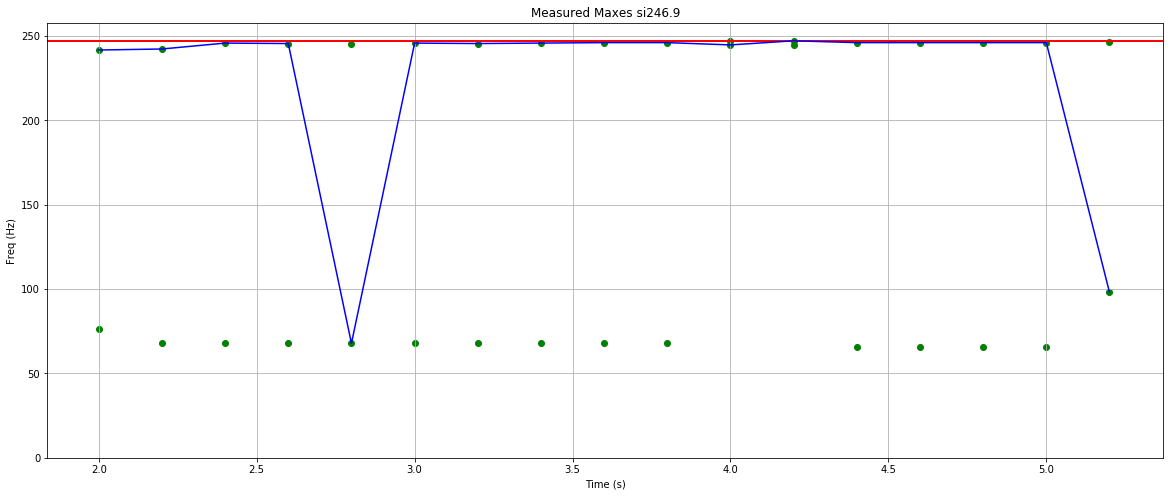

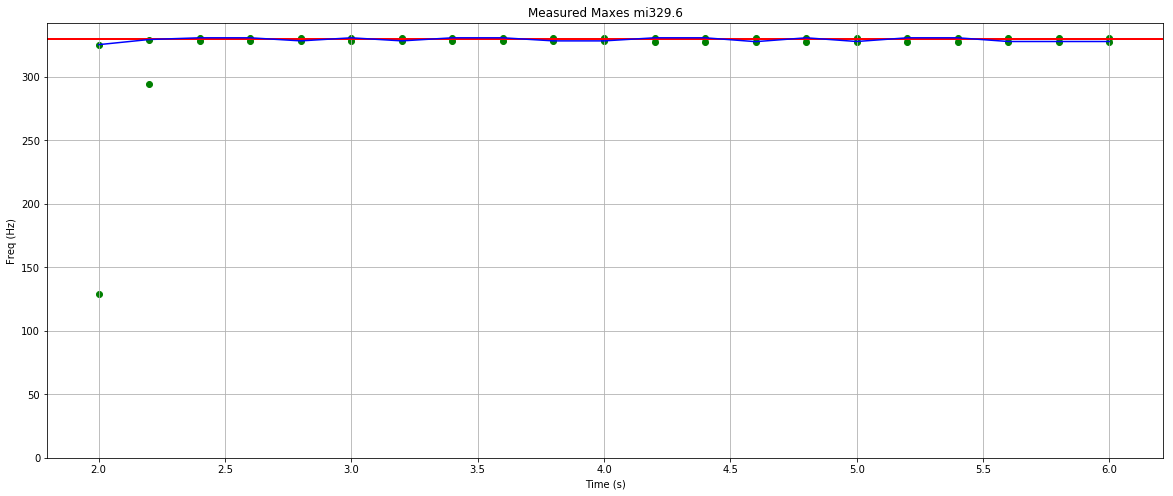

In [20]:
warnings.filterwarnings('ignore')


matplotlib.rcParams['figure.figsize'] = (20.0, 8.0)


WINDOW_LEN = 10
N_CLUSTERS = 2
AMP = 10000

for i, fourier, freq, sound in zip(range(len(SOUNDS)), FOURIER_SAMPLES, FREQUENCIES, SOUNDS):
    measured_note_for_each_window = np.zeros(len(fourier) - WINDOW_LEN)
    for w in range(WINDOW_LEN, len(fourier)):
        window = fourier[w-WINDOW_LEN:w]
        # print(len(window))
        # Here filter the smallest values
        # for some reason kmeans does not work with np.masks
        loudest = np.max(window)
        maxes = np.array([(freq[np.argmax(amp)], np.max(amp)) for amp in window if np.max(amp) > loudest / AMP])

        shaped_maxes = maxes.T[0].reshape(-1, 1)

        kmeans = KMeans(
                n_clusters=N_CLUSTERS,
                random_state=0
            ).fit(shaped_maxes)
        centers = kmeans.cluster_centers_

        # plt.scatter(
        #     y=maxes.T[0],
        #     x=[w*SAMPLE_DUR for _ in range(len(maxes.T[0]))],
        #     s=maxes.T[1],
        # )
        plt.axhline(y=sound[1], color="red")
        M = 2
        while max(maxes.T[0])*1.1 > sound[1]*M:
            plt.axhline(y=sound[1]*M, color="orange")
            M += 1
        for center in centers:
            plt.scatter(
                x=w*SAMPLE_DUR,
                y=center,
                c="green",
            )
    
        arg_center_with_max_points = 0
        max_points = 0
        for j in range(len(centers)):
            mask = np.ma.masked_where(kmeans.labels_ != i, maxes.T[0])
            # print(centers)
            if mask.count() > max_points:
                arg_center_with_max_points = j
                max_points = mask.count()
        # print(center[arg_center_with_max_points], max_points)
        measured_note_for_each_window[w-WINDOW_LEN] = centers[arg_center_with_max_points]
        # MEASURED_NOTES[i] = centers[arg_center_with_max_points]
    plt.plot(
        np.linspace(SAMPLE_DUR*WINDOW_LEN, (len(fourier) - 1)*SAMPLE_DUR, len(fourier) - WINDOW_LEN),
        measured_note_for_each_window,
        c="blue",
    )

    plt.xlabel("Time (s)") 
    plt.ylabel("Freq (Hz)")

    plt.title(f"Measured Maxes {sound[0]}")
    plt.ylim(bottom=0)
    plt.grid()
    plt.show()

warnings.filterwarnings('default')